<a href="https://colab.research.google.com/github/Egoago/Onlab/blob/main/%C3%96nlab.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 2D regression

##Preparing the data

###Defining the control points

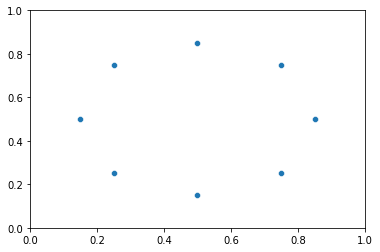

In [17]:
import numpy as np
from matplotlib import pyplot as plt
import seaborn as sns

np.random.seed(1)
points = np.array([
                   [0.25,0.25],
                   [0.5,0.15],
                   [0.75,0.25],
                   [0.85,0.5],
                   [0.75,0.75],
                   [0.5,0.85],
                   [0.25,0.75],
                   [0.15,0.5]
                   ])
sns.scatterplot(x=points[:,0], y=points[:,1]).set(xlim=(0,1),ylim=(0,1));

###Defining training data generator

In [18]:
from tensorflow.keras.utils import Sequence
from math import ceil

class DataGenerator(Sequence):
  seed = 0
  def __init__(self, dataCount, batch_size, controlPoints):
    self.controlPoints = controlPoints
    self.dataCount = dataCount
    self.batch_size = batch_size
    self.seed = DataGenerator.seed
    DataGenerator.seed += 1
    self.randGen = np.random.default_rng(seed=self.seed)

  def __len__(self):
    return ceil(self.dataCount / self.batch_size)

  def dist(self, p):
    return np.linalg.norm(self.controlPoints-p, axis = 1).min()

  def __getitem__(self, idx):
    P = []
    d = []
    for i in range(self.batch_size):
      p = self.randGen.random(2)
      P.append(p)
      d.append(self.dist(p))
    return np.array(P), np.array(d)

  def on_epoch_end(self):
    self.randGen = np.random.default_rng(seed=self.seed)
  
  def getAll(self):
    self.on_epoch_end()
    P = []
    d = []
    for i in range(self.batch_size * self.__len__()):
      p = self.randGen.random(2)
      P.append(p)
      d.append(self.dist(p))
    self.on_epoch_end()
    return np.array(P), np.array(d)

###Creating generators

In [20]:
pointNum = 30000
validSplit = 0.1
testSplit  = 0.1
trainPointNum = int(pointNum*(1-validSplit-testSplit))
validPointNum = int(pointNum*validSplit)
testPointNum = int(pointNum*testSplit)

trainGen = DataGenerator(trainPointNum, 2, points)
validGen = DataGenerator(validPointNum, 32, points)
testGen = DataGenerator(testPointNum, 32, points)

##Creating model

In [28]:
from tensorflow.keras.models import Model
from tensorflow import norm
from tensorflow.math import reduce_mean, abs
import tensorflow as tf
from tensorflow import keras


class CustomModel(Model):
  def __init__(self, *args, **kwargs):
    Model.__init__(self, *args, **kwargs)
    self.stepCounter = 0
    self.eikonalLambda = 0.2

  def train_step(self, data):
    x, y = data
    trainableVariables = self.trainable_variables
    with tf.GradientTape() as backpropTape:
      backpropTape.watch(trainableVariables)

      surfacePred = self(points, training=True)
      with tf.GradientTape() as eikonalTape:
        eikonalTape.watch(x)
        volumePred = self(x, training=True)
      volumeGrad = eikonalTape.gradient(volumePred, x)
      
      surfaceLoss = reduce_mean(abs(surfacePred))
      eikonalLoss = reduce_mean((norm(volumeGrad, 2, -1) - 1) ** 2)
      
      loss = surfaceLoss + self.eikonalLambda * eikonalLoss

    self.optimizer.minimize(loss, trainableVariables, tape=backpropTape)
    return {"loss": loss}
  
  def test_step(self, data):
    x, y = data
    surfacePred = self(points, training=False)
    with tf.GradientTape() as eikonalTape:
      eikonalTape.watch(x)
      volumePred = self(x, training=True)
    volumeGrad = eikonalTape.gradient(volumePred, x)
    
    surfaceLoss = reduce_mean(abs(surfacePred))
    eikonalLoss = reduce_mean((norm(volumeGrad, 2, -1) - 1) ** 2)
    
    loss = surfaceLoss + self.eikonalLambda * eikonalLoss
    return {"loss": loss}

Model: "custom_model_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_8 (InputLayer)         [(None, 2)]               0         
_________________________________________________________________
dense_21 (Dense)             (None, 64)                192       
_________________________________________________________________
dense_22 (Dense)             (None, 64)                4160      
_________________________________________________________________
dense_23 (Dense)             (None, 1)                 65        
Total params: 4,417
Trainable params: 4,417
Non-trainable params: 0
_________________________________________________________________


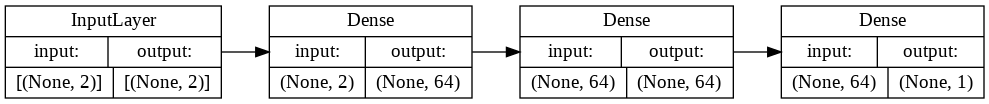

In [29]:
from tensorflow.keras.layers import Dense, Input

inputLayer = Input(shape=(2,))
hiddenLayer1 = Dense(64, activation='relu')(inputLayer)
hiddenLayer2 = Dense(64, activation='relu')(hiddenLayer1)
outputLayer = Dense(1, activation='linear')(hiddenLayer2)

model = CustomModel(inputs = inputLayer, outputs = outputLayer)
model.summary()
keras.utils.plot_model(model, show_shapes=True, show_layer_names=False, rankdir='LR')

###Defining the loss function

In [30]:
from tensorflow.keras.callbacks import EarlyStopping

model.compile(optimizer = 'adam')
es = EarlyStopping(min_delta = 1e-5,
                        patience = 5,
                        verbose = 2,
                        restore_best_weights = True)

##Train

In [31]:
epochs = 10
history = model.fit(trainGen,
                    validation_data = validGen,
                    verbose = 1,
                    #callbacks = [es],
                    epochs = epochs)

Epoch 1/10
12000/12000 [==============================] - 24s 2ms/step - loss: 0.0207 - val_loss: 0.0024
Epoch 2/10
12000/12000 [==============================] - 24s 2ms/step - loss: 0.0032 - val_loss: 0.0050
Epoch 3/10
 2046/12000 [====>.........................] - ETA: 19s - loss: 0.0041

KeyboardInterrupt: ignored

##Evaluate

loss on test data: 0.004861194174736738


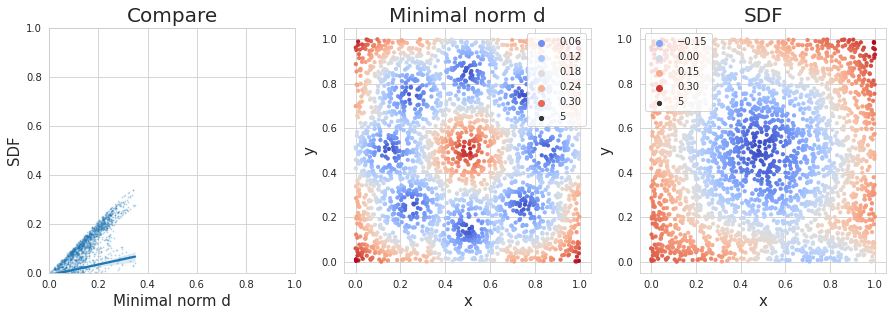

In [32]:
testX, testY = testGen.getAll()
print(f'loss on test data: {model.evaluate(testX, testY, verbose=0, batch_size=32)}')
prediction = model.predict(testX)
plots = []
sns.set_style("whitegrid")
fig, axs = plt.subplots(ncols = 3,
                        figsize=(15,4.5))
plots.append(sns.regplot(x = testY, y = prediction, ax=axs[0], scatter_kws={'s':1, 'alpha':0.2}))
plots.append(sns.scatterplot(x=testX[:,0], y=testX[:,1], hue = testY, size = 5, linewidth = 0, palette='coolwarm', ax=axs[1]))
plots.append(sns.scatterplot(x=testX[:,0], y=testX[:,1], hue = prediction.reshape(-1), size = 5, linewidth = 0, palette='coolwarm', ax=axs[2]))
plots[0].set_title('Compare', fontsize = 20)
plots[0].set_ylabel('SDF', fontsize = 15)
plots[0].set(ylim=(0,1),xlim=(0,1))
plots[0].set_xlabel('Minimal norm d', fontsize = 15)
plots[1].set_xlabel('x', fontsize = 15)
plots[1].set_ylabel('y', fontsize = 15)
plots[1].set_title('Minimal norm d', fontsize = 20)
plots[2].set_xlabel('x', fontsize = 15)
plots[2].set_ylabel('y', fontsize = 15)
plots[2].set_title('SDF', fontsize = 20);

##Plot Model

<Figure size 936x720 with 0 Axes>

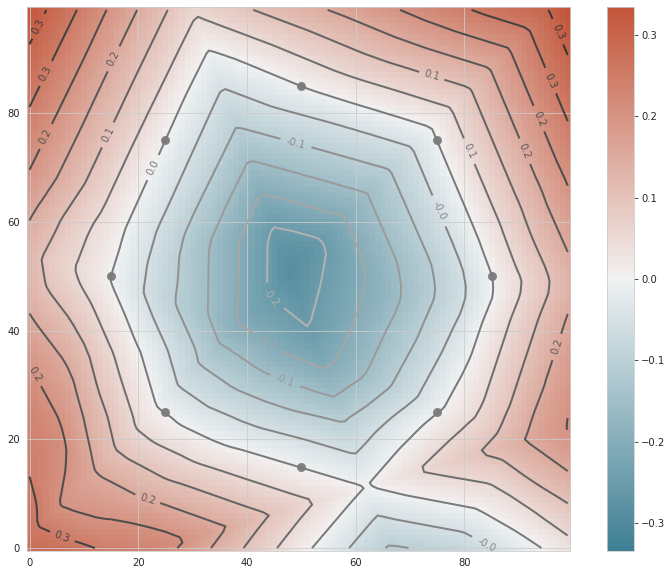

In [33]:
from matplotlib import colors
from numpy import exp,arange
from pylab import meshgrid,cm,imshow,contour,clabel,colorbar

plt.figure(figsize=(13,10))
resolution = 100
grid = np.empty((resolution*resolution,2))
for y in range(resolution):
  for x in range(resolution):
    grid[y*resolution+x] = [x/resolution, y/resolution]
prediction = np.array(model.predict(grid).reshape((resolution,resolution)))
grid = []

plt.figure(figsize=(13,10))
max = np.max(prediction)
min = np.min(prediction)
if (abs(min) > max):
  max = abs(min)
im = imshow(prediction,
            cmap = sns.diverging_palette(220, 20, as_cmap=True),
            origin='lower',norm = colors.Normalize(vmin=-max, vmax=max))
colorbar(im)
cset = contour(prediction,arange(-0.6,0.6,0.05),linewidths=2,cmap='gray_r')
clabel(cset,inline=True,fmt='%1.1f',fontsize=10)
plot = sns.scatterplot(x=points[:,0]*resolution,
                y=points[:,1]*resolution,
                color = 'grey',
                s = 80, linewidth = 0)